<a href="https://colab.research.google.com/github/MiaoHu17/Cutomer-Churn-Classification/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from scipy.stats import chi2_contingency

import xgboost as xgb
from xgboost import plot_importance

import numpy as np

In [3]:
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#Data Cleaning

Check NAs

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Check Empty or Blank Space

In [5]:
for col in df.columns:
  temp = []
  status = ''
  if len(df[df[col]==''])>0:
    status = 'Yes with Empty String'
  elif len(df[df[col]==' '])>0:
    status = 'Yes with Blank Space'
  else:
    status = 'No'
  print("{:<20} {:<20}".format(col,status))

customerID           No                  
gender               No                  
SeniorCitizen        No                  
Partner              No                  
Dependents           No                  
tenure               No                  
PhoneService         No                  
MultipleLines        No                  
InternetService      No                  
OnlineSecurity       No                  
OnlineBackup         No                  
DeviceProtection     No                  
TechSupport          No                  
StreamingTV          No                  
StreamingMovies      No                  
Contract             No                  
PaperlessBilling     No                  
PaymentMethod        No                  
MonthlyCharges       No                  
TotalCharges         Yes with Blank Space
Churn                No                  


Remove those entries with only empty string or blank space

In [6]:
df = df[df['TotalCharges']!=' ']
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: float(x))

#Exploratory Data Analysis

Through the data visulization, we can see that the dataset is highly imbalanced as there are 5163 : 1869 - (No : Yes)

5163 1869


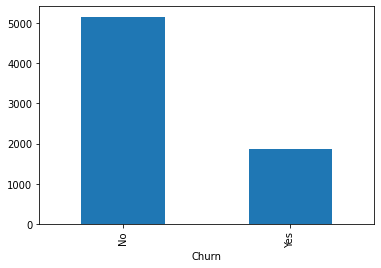

In [7]:
df.groupby(['Churn']).size().plot(kind='bar')
print((df['Churn'] == 'No').sum(),(df['Churn'] == 'Yes').sum())

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
category_columns = ['gender','SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']

numerical_columns = ['tenure','MonthlyCharges', 'TotalCharges']

In [10]:
def get_statistics_churn(x,indicator):
  d = {}
  unique = df[x].unique()
  for item in unique:
    total = (df[x]==item).sum()
    temp = df[df['Churn']==indicator]
    num = (temp[x] == item).sum()/total
    d[item] = num
  return d

In [11]:
def plot_stacked_bar(x):
  '''
  input:
  x: list containing columns name for plot
  output:
  matplot object with 16 plots showing the stacked percentage bar chart for each class of the categorical variables.
  '''
  plt.figure(figsize=(50, 15))
  i = 1
  for item in x:
    d1 = get_statistics_churn(item,'Yes')
    d2 = get_statistics_churn(item,'No')
    temp = pd.DataFrame(d1,index=['Yes']).append(pd.DataFrame(d2,index=['No'])).transpose()
    names = df[item].unique()
    yes = temp['Yes']
    no = temp['No']
    row = range(len(temp))
    plt.subplot(4,4,i)
    plt.bar(row,yes)
    plt.bar(row,no,bottom=yes)
    plt.xticks(row, names)
    plt.xlabel(item)
    i+=1

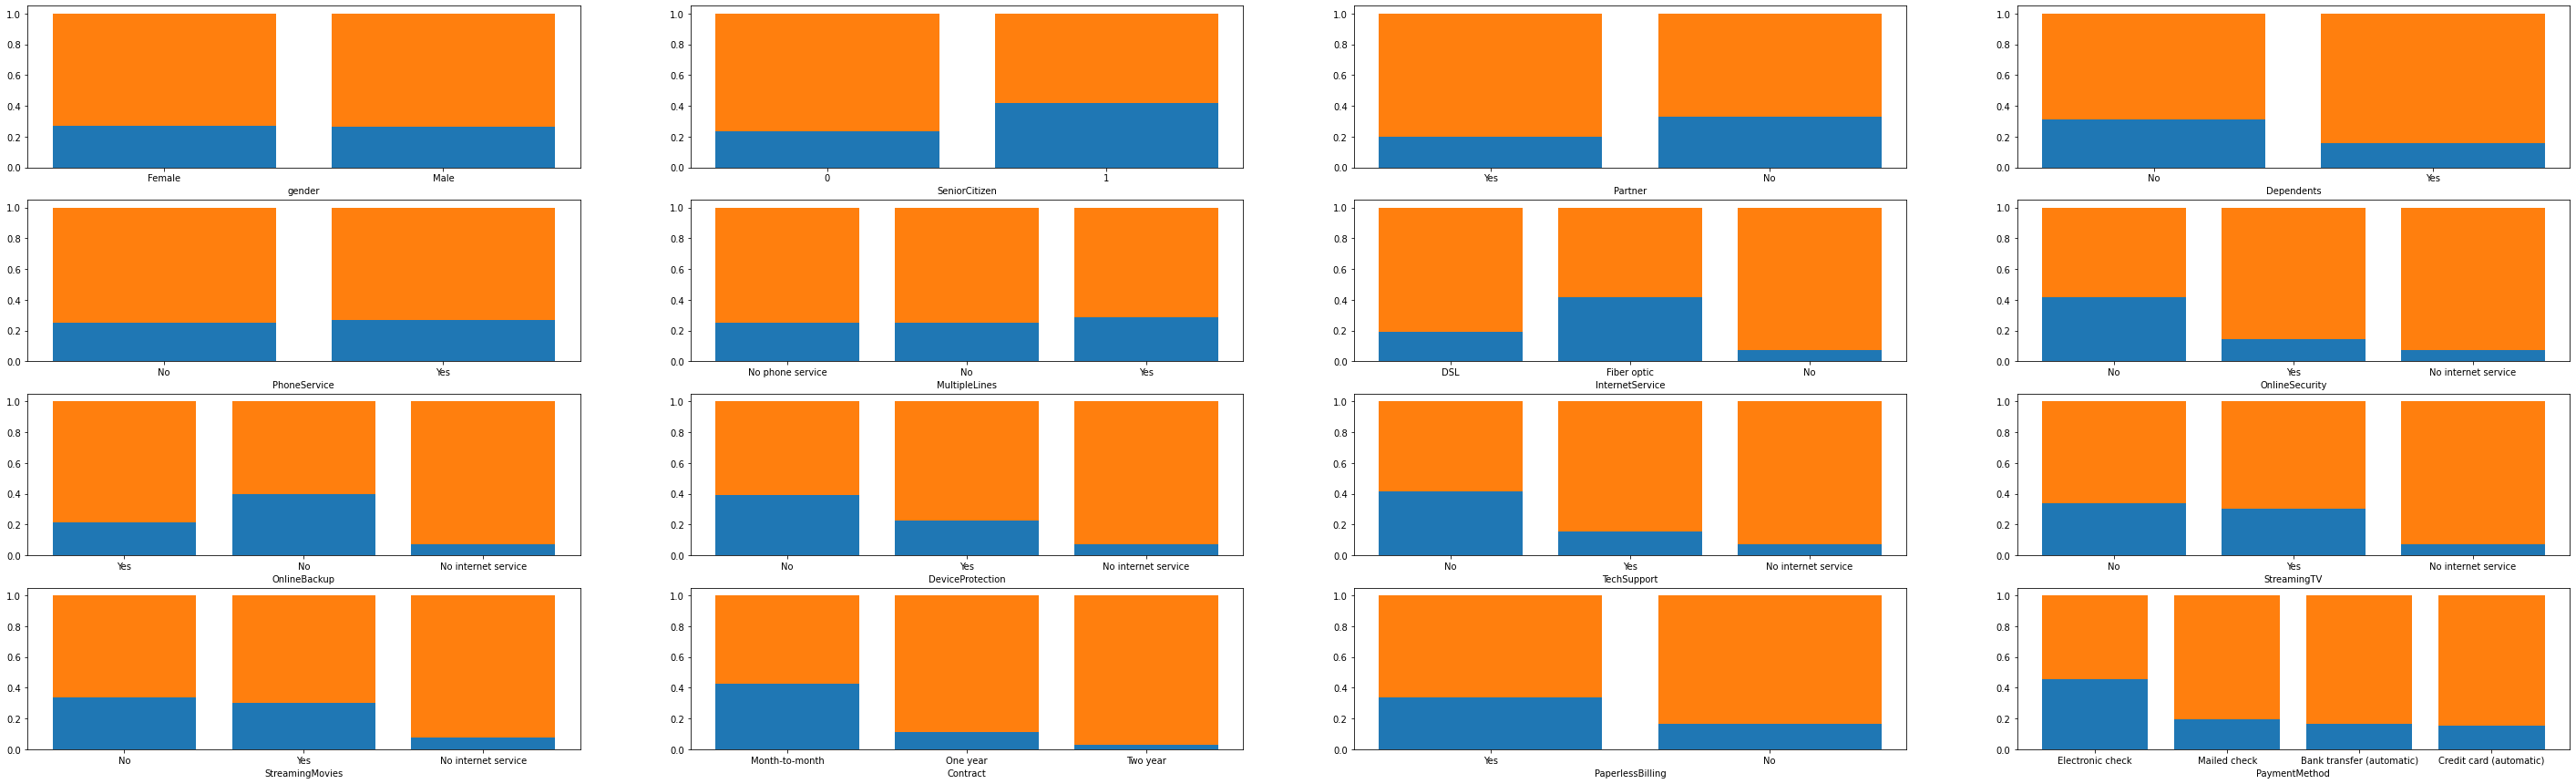

In [12]:
plot_stacked_bar(category_columns[:-1])

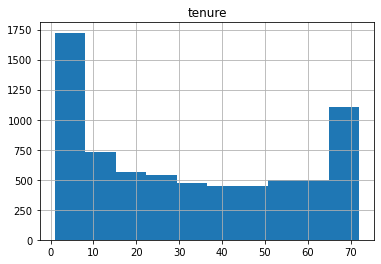

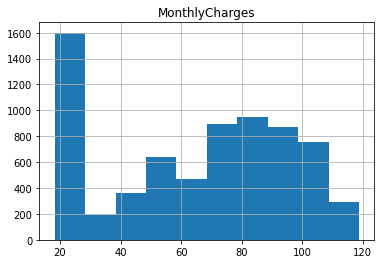

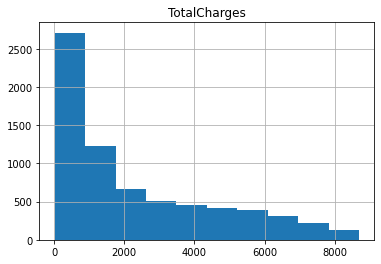

In [14]:
df_numerical  = df[numerical_columns]
for item in numerical_columns:
  df_numerical.hist(column=item)

Standardized the continuous variables 

In [15]:
for col in df_numerical:
  df_numerical.loc[:,col] = (df_numerical[col]-df_numerical[col].mean())/df_numerical[col].std()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Transform classes in categorical varaibles to number representation

In [16]:
df_categorical = df[category_columns]

In [17]:
for col in category_columns:
  df_categorical[col], _ = pd.factorize(df_categorical[col])

target = df_categorical[['Churn']]
df_categorical = df_categorical.drop('Churn',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Use Chi-Square test to test if a variable should be included in the models.

In [18]:
chi2_values = []
p_values = []

for column in df_categorical.columns:
    contingency = pd.crosstab(df_categorical[column], df['Churn'])

    chi2_val, p_value, degrees_of_freedom, expected = chi2_contingency(contingency)
    
    chi2_values.append(chi2_val)
    p_values.append(p_value)
    
data = list(zip(df_categorical.columns, chi2_values, p_values))
pd.DataFrame(data = data,
             columns = ['Variable','Chi squared value','p-value'])

,Variable,Chi squared value,p-value
0,gender,0.475455,4.904885e-01
1,SeniorCitizen,158.440816,2.479256e-36
2,Partner,157.503151,3.973798e-36
3,Dependents,186.321639,2.019659e-42
4,PhoneService,0.873733,3.499240e-01
5,MultipleLines,11.271541,3.567927e-03
6,InternetService,728.695614,5.831199e-159
7,OnlineSecurity,846.677389,1.400687e-184
8,OnlineBackup,599.175185,7.776099e-131
9,DeviceProtection,555.880327,1.959389e-121


From the table above, we can conclude that Gender and PhoneService should be excluded from the models as they have a p-value that's higher than 0.05

In [19]:
df_categorical = df_categorical.drop(['gender','PhoneService'],axis=1)

In [20]:
df_data = df_categorical.join(df_numerical)

In [21]:
#Split the whole dataset into Train, Validation and Test set. with 60%, 20% and 20% of the whole dataset, respectively.
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(df_data, target['Churn'], test_size=test_ratio, random_state=2021, stratify=target)

valid_ratio_real = valid_ratio/(1-test_ratio)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_ratio_real, random_state=2021, stratify=y_train)

#Models

We implemented several different machine learning models, including Logistic Regression, Decision Tree, Random Forest, XGBoost, Support Vector Machine and Multilayer Perceptron

##Logistic Regression

Using GridSearch to tune the hyperparameters for Logistic Regression the best hyper parameter combination is [C=1.01, max_iter of 100 and using Liblinear solver

In [ ]:
clf = LogisticRegression(random_state = 2021, class_weight='balanced')
parameters ={'C':np.arange(0.01,20,1),
       'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
       'max_iter':np.arange(100,500,50)}
LG_dt = GridSearchCV(clf,parameters).fit(X_train, y_train)
print(pd.DataFrame(LG_dt.cv_results_))
LG_dt.best_params_

     mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0         0.042930      0.004085  ...        0.013877              769
1         0.030919      0.001483  ...        0.013877              769
2         0.015192      0.000275  ...        0.011417              761
3         0.029329      0.003555  ...        0.013877              769
4         0.033846      0.001465  ...        0.013877              769
..             ...           ...  ...             ...              ...
795       0.049165      0.001175  ...        0.014908              113
796       0.040388      0.001782  ...        0.014908              113
797       0.018833      0.000157  ...        0.014908              113
798       0.054886      0.007000  ...        0.014908              113
799       0.034796      0.001074  ...        0.014908              113

[800 rows x 16 columns]


{'C': 1.01, 'max_iter': 100, 'solver': 'liblinear'}

Fit the model and obtain the Accuracy and F1-Score on validation set

In [108]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 2021, solver='liblinear', C=1.01, max_iter=100, class_weight='balanced').fit(X_train,y_train)
print('The Accuracy on Validation Set is {:2.2%} for Logistic Regression'.format(clf.score(X_valid, y_valid)))
print('The F1-Score on Validation Set is {:2.2%} for Logistic Regression'.format(f1_score(y_valid,clf.predict(X_valid),average="weighted")))
print(classification_report(y_valid, clf.predict(X_valid)))

The Accuracy on Validation Set is 75.34% for Logistic Regression
The F1-Score on Validation Set is 76.55% for Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.77      1407



##Decision Tree

In [ ]:
clf1 = DecisionTreeClassifier(random_state = 2021, class_weight='balanced')
parameters ={'max_depth':np.arange(5,20,1),
       'min_samples_split':np.arange(2,15,1),
       'min_samples_leaf':np.arange(1,15,1)}
GS_dt = GridSearchCV(clf1,parameters,n_jobs=-1).fit(X_train, y_train)
print(pd.DataFrame(GS_dt.cv_results_))
GS_dt.best_params_

      mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0          0.019910      0.003058  ...        0.007267               66
1          0.020734      0.003590  ...        0.007267               66
2          0.020404      0.003974  ...        0.007267               66
3          0.020867      0.003594  ...        0.007267               66
4          0.019502      0.003026  ...        0.007267               66
...             ...           ...  ...             ...              ...
2725       0.024211      0.003884  ...        0.018176              757
2726       0.022785      0.001005  ...        0.018176              757
2727       0.022675      0.000831  ...        0.018176              757
2728       0.022530      0.000850  ...        0.018176              757
2729       0.027485      0.005059  ...        0.018176              757

[2730 rows x 16 columns]


{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [99]:
clf1 = DecisionTreeClassifier(max_depth=5,min_samples_leaf=9,min_samples_split=2,random_state = 2021, class_weight='balanced').fit(X_train, y_train)
print('The Accuracy on Validation Set is {:2.2%} for Decision Tree'.format(clf1.score(X_valid, y_valid)))
print('The F1-Score on Validation Set is {:2.2%} for Decision Tree'.format(f1_score(y_valid,clf1.predict(X_valid),average="weighted")))
print(classification_report(y_valid, clf1.predict(X_valid)))

The Accuracy on Validation Set is 77.61% for Decision Tree
The F1-Score on Validation Set is 78.48% for Decision Tree
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1033
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.78      0.78      1407



##Random Forest

In [119]:
clf2 = RandomForestClassifier(max_depth=5,min_samples_leaf=9,min_samples_split=2,random_state = 2021, n_estimators = 250, class_weight='balanced').fit(X_train, y_train)
print('The Accuracy on Validation Set is {:2.2%} for Random Forest'.format(clf2.score(X_valid, y_valid)))
print('The F1-Score on Validation Set is {:2.2%} for Random Forest'.format(f1_score(y_valid,clf2.predict(X_valid),average="weighted")))
print(classification_report(y_valid, clf2.predict(X_valid)))

The Accuracy on Validation Set is 77.75% for Random Forest
The F1-Score on Validation Set is 78.78% for Random Forest
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1033
           1       0.56      0.80      0.66       374

    accuracy                           0.78      1407
   macro avg       0.73      0.78      0.75      1407
weighted avg       0.82      0.78      0.79      1407



##Support Vector Machine

In [ ]:
svc = SVC(random_state=2021,class_weight='balanced',gamma='auto')
parameters ={'C': np.arange(0.01,10,1),'kernel':['linear','poly','rbf','sigmoid']}
SVM_dt = GridSearchCV(svc,parameters,n_jobs=-1).fit(X_train, y_train)
print(pd.DataFrame(SVM_dt.cv_results_))
SVM_dt.best_params_

    mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.441912      0.030480  ...        0.011085               26
1        0.590758      0.011287  ...        0.013983               40
2        0.885218      0.010291  ...        0.012788               30
3        1.139122      0.011812  ...        0.008534                9
4        0.591805      0.026650  ...        0.012489               19
5        0.523261      0.010203  ...        0.014069               29
6        0.706105      0.010712  ...        0.018386               14
7        0.646972      0.065329  ...        0.013999               31
8        0.755701      0.019577  ...        0.012821               20
9        0.541022      0.016330  ...        0.011896               12
10       0.729911      0.007088  ...        0.017697                6
11       0.615355      0.075202  ...        0.014803               32
12       0.921154      0.020797  ...        0.013593               22
13       0.564356   

{'C': 4.01, 'kernel': 'rbf'}

In [101]:
svc = SVC(C=4.01,random_state=2021,class_weight='balanced',gamma='auto').fit(X_train, y_train)
print('The Accuracy on Validation Set is {:2.2%} for Support Vector Machine'.format(svc.score(X_valid, y_valid)))
print('The F1-Score on Validation Set is {:2.2%} for Support Vector Machine'.format(f1_score(y_valid,svc.predict(X_valid),average="weighted")))
print(classification_report(y_valid, svc.predict(X_valid)))

The Accuracy on Validation Set is 77.47% for Support Vector Machine
The F1-Score on Validation Set is 78.43% for Support Vector Machine
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1033
           1       0.56      0.76      0.64       374

    accuracy                           0.77      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.77      0.78      1407



##XGBoost

In [92]:
xg_cla = xgb.XGBClassifier(random_state = 2020, n_estimators =1000, n_jobs =-1)
xg_cla.fit(X_train,y_train)
preds_xg = xg_cla.predict(X_valid)
print(classification_report(y_valid, preds_xg))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [107]:
preds_xg = xg_cla.predict(X_valid)
print('The F1-Score on Validation Set is {:2.2%} for Multilayer Perceptron'.format(f1_score(y_valid,preds_xg,average="weighted")))

The F1-Score on Validation Set is 78.72% for Multilayer Perceptron


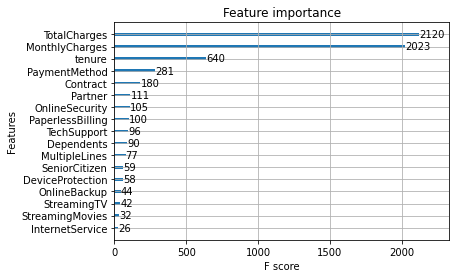

In [ ]:
plot_importance(xg_cla)

##Multilayer Perceptron

In [22]:
clf3 = MLPClassifier(random_state = 2021,max_iter=500,solver='sgd').fit(X_train, y_train)
print('The Accuracy on Validation Set is {:2.2%} for Multilayer Perceptron'.format(clf3.score(X_valid, y_valid)))
print('The F1-Score on Validation Set is {:2.2%} for Multilayer Perceptron'.format(f1_score(y_valid,clf3.predict(X_valid),average="weighted")))
print(classification_report(y_valid, clf3.predict(X_valid)))

The Accuracy on Validation Set is 80.38% for Multilayer Perceptron
The F1-Score on Validation Set is 79.48% for Multilayer Perceptron
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



#Conclusion

| Model                  |    F1-Score    |
|------------------------|----------------|
| Logistic Regression    |    76.55%      |
| Decision Tree          |    78.48%      |
| Support Vector Machine |    78.43%      |
| Multilayer Perceptron  |    79.48%      |
| Random Forest          |    78.78%      |
| XGBoost                |    78.72%      |

The winner on validation set is Multilayer Perceptron, therefore we would use it on the test set. Additionally, from feature importance calculated in XGBoost, we have the insight that monthly charges, total charges and tenure with the company are really important to detect if a customer would churn or not.

In [27]:
pred_test = clf3.predict(X_test)
print('The Accuracy on Test Set is {:2.2%} for Multilayer Perceptron'.format(clf3.score(X_test, y_test)))
print('The F1-Score on Test Set is {:2.2%} for Multilayer Perceptron'.format(f1_score(y_test,pred_test,average="weighted")))
print(classification_report(y_test,pred_test))

The Accuracy on Test Set is 80.03% for Multilayer Perceptron
The F1-Score on Test Set is 79.31% for Multilayer Perceptron
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



We found that XG Boost performs the best in this case. The company can use this model to predict whether the customers will churn or not and help them to keep their customers under most situation. 

We used feature ranking to find most influent features In this case, “Monthly Charges”, “Total Charges” and “Tenure”, the company can focus on these features and get the better result and the lowest cost.